In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.data import Iterator, BucketIterator
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import tqdm
import spacy
from spacy.symbols import ORTH

from google.colab import drive
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/gdrive')
data_dir = 'gdrive/My Drive/Colab Notebooks/data/headlines' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


I am using Google Colab notebook, so I had to provide access to my files from within the notebook

# Preprocessing declaration

First we need to define a function to be used for tokenization. I will use Spacy library. 

What is also necessary is to define data fields. It is a way to declare what type of preprocessing should be done on raw text. 

Note that our labels are ready to be used, we don't need vocabulary mapping for them.

In [0]:
tok = spacy.load('en')

def spacy_tokenize(x):
    return [token.text for token in tok.tokenizer(x)]

TEXT = Field(sequential=True, tokenize=spacy_tokenize, lower=True)
LABEL = Field(sequential=False, use_vocab=False)

# Dataset classes

When working with PyTorch we always need to declare our dataset classes. In this case it is appropriate to use tabular dataset from torchtext package. Each headline and corresponding class are together wrapped in Example object.

In [0]:
datafields = [("headline", TEXT), ("is_sarcastic", LABEL)]

train_dataset, validation_dataset = TabularDataset.splits(path=data_dir, train='train.csv', validation="val.csv",
                                          format='csv', skip_header=True, fields=datafields)

test_dataset = TabularDataset(path=data_dir+"/test.csv", format='csv', skip_header=True, fields=datafields)

We can verify if the rows are represented correctly.

In [4]:
train_dataset[0]

In [5]:
train_dataset[0].__dict__.keys()

dict_keys(['headline', 'is_sarcastic'])

In [6]:
train_dataset[0].headline[:4]

['woman', 'has', 'no', 'business']

When working with text data and neural netoworks, we need to build a vocabulary. that is mapping from words to their corresponding integer ids.

Training dataset is used for that purpose. For my model, I will use GloVe 100-dimensional word embeddings.

In [0]:
TEXT.build_vocab(train_dataset, vectors="glove.6B.100d")

For text data, PyTorch uses the convention of iterators, that enable us to iterate over the datasets.

In each iteration over the dataset we get a batch of headlines and their labels.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_iterator, val_iterator = BucketIterator.splits((train_dataset, validation_dataset), batch_sizes=(64, 64), device=device,
                                                     sort_key=lambda x: len(x.headline), sort_within_batch=False, repeat=False)

test_iterator = Iterator(test_dataset, batch_size=64, device=device, sort=False, sort_within_batch=False, repeat=False)

We can see that each batch consists of 64 examples. The size of headlines tensor is determined by length of the longest sentence in the batch.

In [9]:
batch = next(train_iterator.__iter__()); batch


[torchtext.data.batch.Batch of size 64]
	[.headline]:[torch.cuda.LongTensor of size 17x64 (GPU 0)]
	[.is_sarcastic]:[torch.cuda.LongTensor of size 64 (GPU 0)]

In [10]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'headline', 'is_sarcastic'])

For conveniance, we can define a wrapper for each batch: while iterating over a dataset we will get a touple (headline, label).

In [0]:
class BatchWrapper:
      def __init__(self, dl, x_var, y_vars):
            self.dl, self.x_var, self.y_vars = dl, x_var, y_vars

      def __iter__(self):
        for batch in self.dl:
                  x = getattr(batch, self.x_var)

                  if self.y_vars is not None:
                        y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
                  else:
                        y = torch.zeros((1))

                  yield (x, y)

      def __len__(self):
            return len(self.dl)


In [0]:
train_dataloader = BatchWrapper(train_iterator, "headline", ["is_sarcastic"])
valid_dataloader = BatchWrapper(val_iterator, "headline", ["is_sarcastic"])
test_dataloader = BatchWrapper(test_iterator, "headline", ["is_sarcastic"])

For this task, I'll use a network that embedds the headline using embedding layer first, then the vectors are passed through LSTM and hidden layer, and then output layer. In order to get class probabilty I am using sigmoid function and return the output.

What I mean by embedding layer? It is a special layer that provides a lookup for a word in embeddings space. It's a theoretical, multidimensional space, in which similar words appear close to each other. Such a representation is able to encode a lot of information about the language, it's semantics and structure. They are build on large portions of text, called corpuses - like a whole Wikipedia! I am using GloVe embeddings here.

In [0]:
class SimpleLSTM(nn.Module):
    def __init__(self, hidden_dim, emb_dim=100, recurrent_dropout=0.1):
      
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=1, dropout=recurrent_dropout)

        self.predictor = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]

        preds = self.predictor(feature).squeeze()
        preds = self.sigmoid(preds)
        return preds

In [14]:
model = SimpleLSTM(hidden_dim=500, recurrent_dropout=0.2)

weight_matrix = TEXT.vocab.vectors
model.embedding.weight.data.copy_(weight_matrix)
model.cuda()
model

SimpleLSTM(
  (embedding): Embedding(19723, 100)
  (encoder): LSTM(100, 500, dropout=0.2)
  (predictor): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace=True)
)

We are set up now! Time to write training loop, decide on training parameters like optimizer, learning rate and number of epochs. Depending on the task we are working on, appropriate loss function must be used. In case of binary classification, we can stick to Binary Cross Entropy.

In [15]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_func = nn.BCELoss()

epochs = 50

train_epoch_losses = []
validation_epoch_losses = []

for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train()

    for x, y in tqdm.tqdm(train_dataloader):

        optimizer.zero_grad()

        y_pred = model(x)
        loss = loss_func(y_pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_epoch_losses.append(epoch_loss)

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
      for x, y in valid_dataloader:
          y_pred = model(x)
          loss = loss_func(y_pred, y)
          val_loss += loss.item() * x.size(0)

    val_loss /= len(validation_dataset)
    validation_epoch_losses.append(val_loss)
    print(f'\n Epoch: {epoch}, Training loss: {round(epoch_loss, 4)}, Validation loss: {round(val_loss, 4)}')


  2%|▏         | 4/233 [00:00<00:06, 36.60it/s]


 Epoch: 1, Training loss: 0.2304, Validation loss: 0.127


  2%|▏         | 5/233 [00:00<00:04, 49.59it/s]


 Epoch: 2, Training loss: 0.2205, Validation loss: 0.1345


  2%|▏         | 5/233 [00:00<00:04, 46.36it/s]


 Epoch: 3, Training loss: 0.1989, Validation loss: 0.122


  2%|▏         | 5/233 [00:00<00:04, 49.56it/s]


 Epoch: 4, Training loss: 0.1717, Validation loss: 0.122


  2%|▏         | 5/233 [00:00<00:05, 44.78it/s]


 Epoch: 5, Training loss: 0.1633, Validation loss: 0.1195


  3%|▎         | 6/233 [00:00<00:04, 52.54it/s]


 Epoch: 6, Training loss: 0.1581, Validation loss: 0.1171


  2%|▏         | 5/233 [00:00<00:04, 49.65it/s]


 Epoch: 7, Training loss: 0.1526, Validation loss: 0.1167


  2%|▏         | 5/233 [00:00<00:04, 49.03it/s]


 Epoch: 8, Training loss: 0.1483, Validation loss: 0.1176


  2%|▏         | 5/233 [00:00<00:04, 49.74it/s]


 Epoch: 9, Training loss: 0.1457, Validation loss: 0.1144


  3%|▎         | 6/233 [00:00<00:04, 51.56it/s]


 Epoch: 10, Training loss: 0.1428, Validation loss: 0.1124


  3%|▎         | 6/233 [00:00<00:04, 53.26it/s]


 Epoch: 11, Training loss: 0.1392, Validation loss: 0.1132


  3%|▎         | 6/233 [00:00<00:04, 48.41it/s]


 Epoch: 12, Training loss: 0.1346, Validation loss: 0.1141


  2%|▏         | 4/233 [00:00<00:05, 38.53it/s]


 Epoch: 13, Training loss: 0.1339, Validation loss: 0.1092


  2%|▏         | 4/233 [00:00<00:05, 39.92it/s]


 Epoch: 14, Training loss: 0.1308, Validation loss: 0.1125


  3%|▎         | 6/233 [00:00<00:04, 53.29it/s]


 Epoch: 15, Training loss: 0.1291, Validation loss: 0.1122


  2%|▏         | 5/233 [00:00<00:04, 45.77it/s]


 Epoch: 16, Training loss: 0.1249, Validation loss: 0.1055


  3%|▎         | 6/233 [00:00<00:04, 53.26it/s]


 Epoch: 17, Training loss: 0.1198, Validation loss: 0.1104


  2%|▏         | 5/233 [00:00<00:04, 46.19it/s]


 Epoch: 18, Training loss: 0.1239, Validation loss: 0.1053


  2%|▏         | 5/233 [00:00<00:05, 45.07it/s]


 Epoch: 19, Training loss: 0.1179, Validation loss: 0.1052


  3%|▎         | 6/233 [00:00<00:04, 53.91it/s]


 Epoch: 20, Training loss: 0.1127, Validation loss: 0.0963


  2%|▏         | 5/233 [00:00<00:04, 47.50it/s]


 Epoch: 21, Training loss: 0.1123, Validation loss: 0.0958


  2%|▏         | 5/233 [00:00<00:04, 47.79it/s]


 Epoch: 22, Training loss: 0.1071, Validation loss: 0.0905


  2%|▏         | 5/233 [00:00<00:04, 49.58it/s]


 Epoch: 23, Training loss: 0.1062, Validation loss: 0.0902


  3%|▎         | 6/233 [00:00<00:04, 55.42it/s]


 Epoch: 24, Training loss: 0.1042, Validation loss: 0.0897


  2%|▏         | 5/233 [00:00<00:04, 49.27it/s]


 Epoch: 25, Training loss: 0.1023, Validation loss: 0.0933


  3%|▎         | 6/233 [00:00<00:04, 54.75it/s]


 Epoch: 26, Training loss: 0.1014, Validation loss: 0.089


  3%|▎         | 6/233 [00:00<00:04, 54.26it/s]


 Epoch: 27, Training loss: 0.0981, Validation loss: 0.0911


  2%|▏         | 5/233 [00:00<00:04, 47.23it/s]


 Epoch: 28, Training loss: 0.0967, Validation loss: 0.0878


  3%|▎         | 6/233 [00:00<00:04, 52.51it/s]


 Epoch: 29, Training loss: 0.0937, Validation loss: 0.0839


  2%|▏         | 5/233 [00:00<00:04, 47.19it/s]


 Epoch: 30, Training loss: 0.0945, Validation loss: 0.081


  2%|▏         | 5/233 [00:00<00:04, 48.83it/s]


 Epoch: 31, Training loss: 0.0933, Validation loss: 0.0868


  3%|▎         | 6/233 [00:00<00:04, 52.72it/s]


 Epoch: 32, Training loss: 0.0867, Validation loss: 0.0892


  2%|▏         | 5/233 [00:00<00:04, 49.48it/s]


 Epoch: 33, Training loss: 0.0877, Validation loss: 0.0868


  2%|▏         | 5/233 [00:00<00:04, 48.96it/s]


 Epoch: 34, Training loss: 0.0873, Validation loss: 0.0789


  2%|▏         | 5/233 [00:00<00:04, 49.35it/s]


 Epoch: 35, Training loss: 0.0839, Validation loss: 0.0802


  2%|▏         | 5/233 [00:00<00:04, 48.52it/s]


 Epoch: 36, Training loss: 0.0824, Validation loss: 0.0776


  2%|▏         | 5/233 [00:00<00:04, 47.37it/s]


 Epoch: 37, Training loss: 0.0823, Validation loss: 0.0927


  2%|▏         | 5/233 [00:00<00:04, 47.43it/s]


 Epoch: 38, Training loss: 0.0803, Validation loss: 0.0832


  2%|▏         | 5/233 [00:00<00:04, 49.78it/s]


 Epoch: 39, Training loss: 0.0783, Validation loss: 0.0852


  2%|▏         | 5/233 [00:00<00:04, 46.72it/s]


 Epoch: 40, Training loss: 0.0771, Validation loss: 0.0853


  2%|▏         | 5/233 [00:00<00:04, 47.98it/s]


 Epoch: 41, Training loss: 0.0744, Validation loss: 0.0741


  2%|▏         | 5/233 [00:00<00:04, 50.00it/s]


 Epoch: 42, Training loss: 0.0747, Validation loss: 0.0743


  2%|▏         | 5/233 [00:00<00:04, 46.26it/s]


 Epoch: 43, Training loss: 0.0726, Validation loss: 0.0806


  2%|▏         | 4/233 [00:00<00:05, 38.88it/s]


 Epoch: 44, Training loss: 0.0703, Validation loss: 0.088


  2%|▏         | 5/233 [00:00<00:04, 48.84it/s]


 Epoch: 45, Training loss: 0.0698, Validation loss: 0.0776


  3%|▎         | 6/233 [00:00<00:04, 54.64it/s]


 Epoch: 46, Training loss: 0.0666, Validation loss: 0.0736


  2%|▏         | 4/233 [00:00<00:05, 39.58it/s]


 Epoch: 47, Training loss: 0.0644, Validation loss: 0.0705


  3%|▎         | 6/233 [00:00<00:04, 55.34it/s]


 Epoch: 48, Training loss: 0.0645, Validation loss: 0.0733


  3%|▎         | 6/233 [00:00<00:04, 51.33it/s]


 Epoch: 49, Training loss: 0.0636, Validation loss: 0.085


100%|██████████| 233/233 [00:03<00:00, 63.19it/s]



 Epoch: 50, Training loss: 0.0593, Validation loss: 0.0742


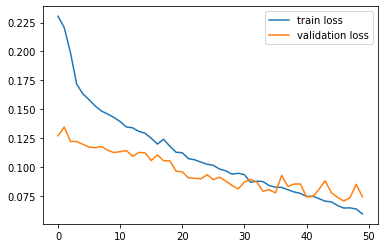

In [16]:
train_plot, = plt.plot(range(len(train_epoch_losses)), train_epoch_losses, label='train loss')
val_plot, = plt.plot(range(len(validation_epoch_losses)), validation_epoch_losses, label='validation loss')
plt.legend(handles=[train_plot, val_plot])
plt.show()

In [0]:
def inference(test_dataloader, test_dataset, criterion):
    test_loss = 0.0
    acc = 0.0

    for x, y in tqdm.tqdm(test_dataloader):
        model.eval()
        with torch.no_grad():
          output = model(x)
          loss = criterion(output, y)
          test_loss += loss.item() * x.size(0)

          output = output.cpu().data.numpy()
          output_binary = np.zeros_like(output, dtype='int')
          output_binary[output >= 0.5] = 1
              
          y = y.cpu().data.numpy().flatten()
          acc += len(np.where(output_binary == y)[0])

    return test_loss / len(test_dataset), acc / len(test_dataset)

In [18]:
test_loss, test_accuracy = inference(test_dataloader, test_dataset, loss_func)
print(f'Testing loss: {test_loss}, testing accuracy: {test_accuracy}')

100%|██████████| 125/125 [00:00<00:00, 196.96it/s]

Testing loss: 0.12399046846334386, testing accuracy: 0.859792006014284


We can see that our model gives a better accuracy that traditional machine learning models. But it is also crucial to notice that when I've tried to train it for longer or used higher learning rate it started to overfit. It might be the case that there is no enough training data. In this case it might be beneficial to stick to traditional machine learning methods: logistic regression or Naive Bayes. They give similar results for this data. They are fast, easy to train and interprete. What also might be the reason is that GloVe embeddings are not the best for this task.